# EDA - Identify significant predictors
- Edited by Rumi Nakagawa
- Spring 2023 Capstone

## SITE US-ton
- WSA  Woody Savannas
- metadata

|     | site_id | dataset | start_year | end_year |                                              file | is_dup | IGBP | elevation |      lat |       long |
|----:|--------:|--------:|-----------:|---------:|--------------------------------------------------:|-------:|-----:|----------:|---------:|-----------:|
| 127 |  US-Ton | FLUXNET |       2001 |     2014 | FLX_US-Ton_FLUXNET2015_FULLSET_MM_2001-2014_1-... |  False |  WSA |     177.0 | 38.43160 | -120.96598 |

# 0. Preparation

## Mount google drive
- Make sure that available access is the user's own drive(no access across files in shared folder)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/

/content/drive/MyDrive


## Import libraries

In [3]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 26.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=4755fe4e3b82a1edb7ca325f52611eee6fc4b7e9cbca2803b05f5f2260fd60b4
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [4]:
# !pip install dython

In [5]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 14.0 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [6]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [7]:
# Import a Spark function from library
from pyspark.sql.functions import col

In [8]:
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from pyspark.sql.functions import desc

import geopandas as gpd
import folium

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from pyspark.ml.classification import RandomForestClassifier
import time
# from dython import nominal

# Apply the default theme
sns.set_theme()


## (to be updated) Get access to blob storage
- Reference from 261

In [9]:
# Put at the top of any notebooks for storing in blob

# from pyspark.sql.functions import col, max

# blob_container = "team06" # The name of your container created in https://portal.azure.com
# storage_account = "apatel" # The name of your Storage account created in https://portal.azure.com
# secret_scope = "team06" # The name of the scope created in your local computer using the Databricks CLI
# secret_key = "team06" # The name of the secret key created in your local computer using the Databricks CLI 
# blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
# mount_path = "/mnt/mids-w261"

## Import csv
sample csv

In [10]:
us_ton_hourly_df = pd.read_csv("data_full_half_hourly_raw_v0_1_US-Ton_mydrive.csv")
# Copied original file. It is needed to store in each user's mydrive


In [11]:
us_ton_hourly_df

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen
0,200105240000,200105240030,26.759,0,19.471,0.0,0.0,0,0.000,301.311,...,0.115580,0.1016,0.2620,0.0409,0.0838,0.3309,0.2952,0.1610,WSA,Temperate
1,200105240030,200105240100,26.156,0,18.690,0.0,0.0,0,0.000,301.311,...,0.115580,0.1016,0.2620,0.0409,0.0838,0.3309,0.2952,0.1610,WSA,Temperate
2,200105240100,200105240130,26.185,0,17.909,0.0,0.0,0,0.000,292.413,...,0.115580,0.1016,0.2620,0.0409,0.0838,0.3309,0.2952,0.1610,WSA,Temperate
3,200105240130,200105240200,26.219,0,17.472,0.0,0.0,0,0.000,292.413,...,0.115580,0.1016,0.2620,0.0409,0.0838,0.3309,0.2952,0.1610,WSA,Temperate
4,200105240200,200105240230,26.349,0,17.035,0.0,0.0,0,0.000,292.413,...,0.115580,0.1016,0.2620,0.0409,0.0838,0.3309,0.2952,0.1610,WSA,Temperate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230923,201412312130,201412312200,3.899,0,10.186,0.0,0.0,0,311.775,239.571,...,0.097872,0.0529,0.1796,0.0251,0.0517,0.2300,0.2168,0.1173,WSA,Temperate
230924,201412312200,201412312230,4.021,0,10.186,0.0,0.0,0,311.775,239.571,...,0.097872,0.0529,0.1796,0.0251,0.0517,0.2300,0.2168,0.1173,WSA,Temperate
230925,201412312230,201412312300,3.401,0,10.186,0.0,0.0,0,311.775,239.571,...,0.097872,0.0529,0.1796,0.0251,0.0517,0.2300,0.2168,0.1173,WSA,Temperate
230926,201412312300,201412312330,2.555,0,10.186,0.0,0.0,0,311.775,239.571,...,0.097872,0.0529,0.1796,0.0251,0.0517,0.2300,0.2168,0.1173,WSA,Temperate


### Add column that explains start time
- whether its start of TIMESTAMP is "XX:00" or "XX:30"
- XX:00 -> A
- XX:30 -> B

In [12]:
len('200701010000')
x = '200701010000'
x[10:]

'00'

In [13]:
def minute_categorical(x):
  if x == '00':
    return 'A'
  if x == '30':
    return 'B'
  else: 
    return 'NA'

us_ton_hourly_df['min_categorical'] = us_ton_hourly_df['TIMESTAMP_START'].apply(lambda x: minute_categorical(str(x)[10:]))

In [14]:
us_ton_hourly_df[['TIMESTAMP_START','min_categorical']]

,TIMESTAMP_START,min_categorical
0,200105240000,A
1,200105240030,B
2,200105240100,A
3,200105240130,B
4,200105240200,A
...,...,...
230923,201412312130,B
230924,201412312200,A
230925,201412312230,B
230926,201412312300,A


In [15]:
# Reduce the amount of dataset 
us_ton_hourly_00_df = us_ton_hourly_df[us_ton_hourly_df['min_categorical'] == 'A']
us_ton_hourly_00_df

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen,min_categorical
0,200105240000,200105240030,26.759,0,19.471,0.0,0.0,0,0.000,301.311,...,0.1016,0.2620,0.0409,0.0838,0.3309,0.2952,0.1610,WSA,Temperate,A
2,200105240100,200105240130,26.185,0,17.909,0.0,0.0,0,0.000,292.413,...,0.1016,0.2620,0.0409,0.0838,0.3309,0.2952,0.1610,WSA,Temperate,A
4,200105240200,200105240230,26.349,0,17.035,0.0,0.0,0,0.000,292.413,...,0.1016,0.2620,0.0409,0.0838,0.3309,0.2952,0.1610,WSA,Temperate,A
6,200105240300,200105240330,24.931,0,16.160,0.0,0.0,0,0.000,292.413,...,0.1016,0.2620,0.0409,0.0838,0.3309,0.2952,0.1610,WSA,Temperate,A
8,200105240400,200105240430,24.949,0,15.286,0.0,0.0,0,0.000,287.821,...,0.1016,0.2620,0.0409,0.0838,0.3309,0.2952,0.1610,WSA,Temperate,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230918,201412311900,201412311930,6.291,0,10.186,0.0,0.0,0,311.775,239.571,...,0.0529,0.1796,0.0251,0.0517,0.2300,0.2168,0.1173,WSA,Temperate,A
230920,201412312000,201412312030,4.998,0,10.186,0.0,0.0,0,311.775,239.571,...,0.0529,0.1796,0.0251,0.0517,0.2300,0.2168,0.1173,WSA,Temperate,A
230922,201412312100,201412312130,3.858,0,10.186,0.0,0.0,0,311.775,239.571,...,0.0529,0.1796,0.0251,0.0517,0.2300,0.2168,0.1173,WSA,Temperate,A
230924,201412312200,201412312230,4.021,0,10.186,0.0,0.0,0,311.775,239.571,...,0.0529,0.1796,0.0251,0.0517,0.2300,0.2168,0.1173,WSA,Temperate,A


### Reference: Distribution of QC flag
- Original dataset

[Text(0.5, 1.0, 'NEE_CUT_REF_QC')]

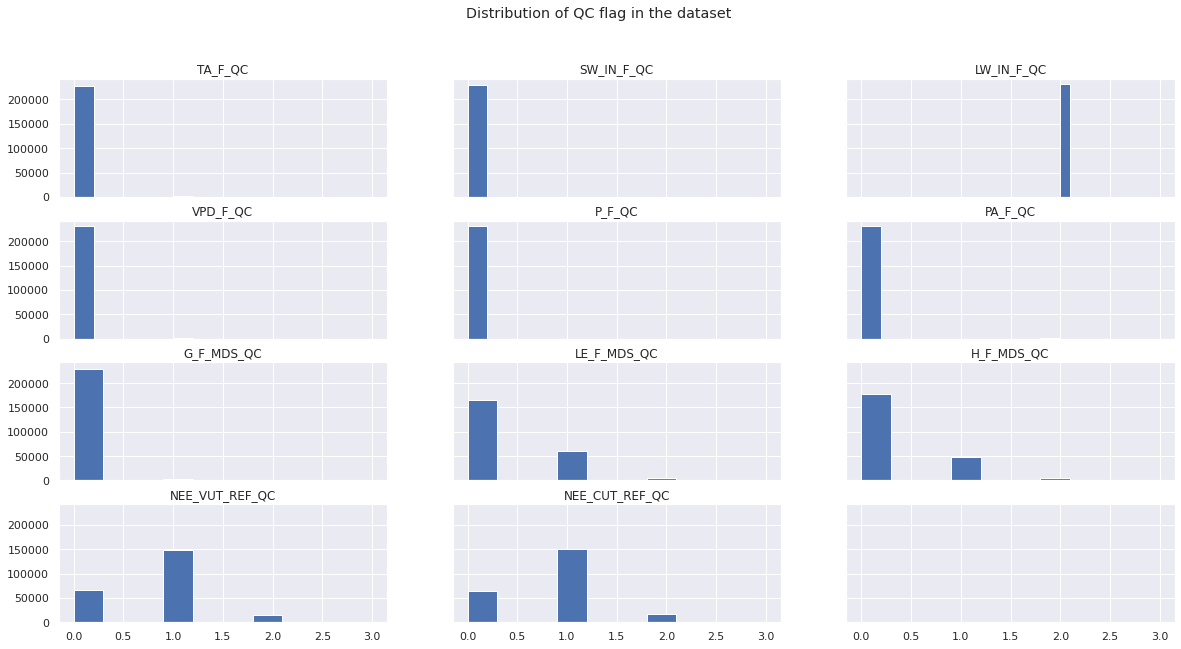

In [16]:
fig, axes = plt.subplots(4, 3, sharex=True, sharey=True,figsize=(20,10))

fig.suptitle('Distribution of QC flag in the dataset')
us_ton_hourly_df['TA_F_QC'].hist(ax=axes[0,0]).set(title='TA_F_QC')
us_ton_hourly_df['SW_IN_F_QC'].hist(ax=axes[0,1]).set(title='SW_IN_F_QC')
us_ton_hourly_df['LW_IN_F_QC'].hist(ax=axes[0,2]).set(title='LW_IN_F_QC')
us_ton_hourly_df['VPD_F_QC'].hist(ax=axes[1,0]).set(title='VPD_F_QC')
us_ton_hourly_df['P_F_QC'].hist(ax=axes[1,1]).set(title='P_F_QC')
us_ton_hourly_df['PA_F_QC'].hist(ax=axes[1,2]).set(title='PA_F_QC')
us_ton_hourly_df['G_F_MDS_QC'].hist(ax=axes[2,0]).set(title='G_F_MDS_QC')
us_ton_hourly_df['LE_F_MDS_QC'].hist(ax=axes[2,1]).set(title='LE_F_MDS_QC')
us_ton_hourly_df['H_F_MDS_QC'].hist(ax=axes[2,2]).set(title='H_F_MDS_QC')
us_ton_hourly_df['NEE_VUT_REF_QC'].hist(ax=axes[3,0]).set(title='NEE_VUT_REF_QC')
us_ton_hourly_df['NEE_CUT_REF_QC'].hist(ax=axes[3,1]).set(title='NEE_CUT_REF_QC')

In [17]:
# display(us_ton_hourly_df)

## Preprocess features

In [18]:
# Original columns
print(len(us_ton_hourly_df.columns))
us_ton_hourly_df.columns

65


Index(['TIMESTAMP_START', 'TIMESTAMP_END', 'TA_F', 'TA_F_QC', 'TA_ERA',
       'SW_IN_POT', 'SW_IN_F', 'SW_IN_F_QC', 'SW_IN_ERA', 'LW_IN_F',
       'LW_IN_F_QC', 'LW_IN_ERA', 'VPD_F', 'VPD_F_QC', 'VPD_ERA', 'P_F',
       'P_F_QC', 'P_ERA', 'PA_F', 'PA_F_QC', 'PA_ERA', 'NETRAD', 'PPFD_IN',
       'G_F_MDS', 'G_F_MDS_QC', 'LE_F_MDS', 'LE_F_MDS_QC', 'LE_CORR',
       'H_F_MDS', 'H_F_MDS_QC', 'H_CORR', 'NEE_VUT_REF', 'NEE_VUT_REF_QC',
       'NEE_CUT_REF', 'NEE_CUT_REF_QC', 'GPP_NT_VUT_REF', 'GPP_DT_VUT_REF',
       'GPP_NT_CUT_REF', 'GPP_DT_CUT_REF', 'RECO_NT_VUT_REF',
       'RECO_DT_VUT_REF', 'RECO_NT_CUT_REF', 'RECO_DT_CUT_REF', 'datetime',
       'year', 'month', 'day', 'hour', 'SITE_ID', 'date', 'NEE_VUT_REF_qa',
       'SW_DIF', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'koppen', 'min_categorical'],
      dtype='object')

## Check how much NA/None exists in each column

In [19]:
us_ton_hourly_df.isna().sum()

TIMESTAMP_START       0
TIMESTAMP_END         0
TA_F                  0
TA_F_QC               0
TA_ERA                0
                   ... 
b6                 5568
b7                 2208
IGBP                  0
koppen                0
min_categorical       0
Length: 65, dtype: int64

In [20]:
us_ton_hourly_countNA = us_ton_hourly_df.isna().sum()
us_ton_hourly_countNA

TIMESTAMP_START       0
TIMESTAMP_END         0
TA_F                  0
TA_F_QC               0
TA_ERA                0
                   ... 
b6                 5568
b7                 2208
IGBP                  0
koppen                0
min_categorical       0
Length: 65, dtype: int64

In [21]:
us_ton_hourly_countNA = pd.DataFrame(us_ton_hourly_df.isna().sum())

NA0_list = list(us_ton_hourly_countNA[us_ton_hourly_countNA[0] == 0].index)
NA_list = list(us_ton_hourly_countNA[us_ton_hourly_countNA[0] != 0].index)

In [22]:
us_ton_hourly_countNA[us_ton_hourly_countNA[0] != 0]

,0
NETRAD,7931
PPFD_IN,233
NEE_VUT_REF_qa,16160
SW_DIF,230928
EVI,2208
NDVI,2208
NIRv,2208
b1,2208
b2,2208
b3,2208


In [23]:
# NA list in site us_ton
NA_list = ['G_F_MDS', 'G_F_MDS_QC', 'LE_F_MDS_QC', 'LE_CORR', 'H_F_MDS_QC',
           'H_CORR','SW_DIF']

In [24]:
# Features used for this analysis
output_var = 'GPP_NT_VUT_REF'
# other options
output_related_var = ['NEE_VUT_REF', 'NEE_VUT_REF_QC',
       'NEE_CUT_REF', 'NEE_CUT_REF_QC', 'GPP_NT_VUT_REF', 'GPP_DT_VUT_REF',
       'GPP_NT_CUT_REF', 'GPP_DT_CUT_REF', 'RECO_NT_VUT_REF',
       'RECO_DT_VUT_REF', 'RECO_NT_CUT_REF', 'RECO_DT_CUT_REF',
       'NEE_VUT_REF_qa']

predictor_var = ['TA_F', 'TA_ERA','SW_IN_POT', 'SW_IN_F','SW_IN_ERA',
                 'LW_IN_F','LW_IN_ERA', 'VPD_F', 'VPD_ERA',
                 'P_F','P_ERA', 'PA_F',  'PA_ERA', 'NETRAD', 'PPFD_IN',
                 'LE_F_MDS', 'H_F_MDS', 'EVI', 'NDVI', 'NIRv',
                 'b1', 'b2', 'b3', 'b4', 'b5', 'b6','b7']

other_var =  ['TIMESTAMP_START', 'TIMESTAMP_END', 'datetime',
              'year', 'month', 'day', 'hour', 'SITE_ID', 'date', 'IGBP',
              'koppen']

qc_flags = ['TA_F_QC','SW_IN_F_QC','LW_IN_F_QC','VPD_F_QC',
            'P_F_QC', 'PA_F_QC','G_F_MDS_QC', 'LE_F_MDS_QC',
            'H_F_MDS_QC'] 

NA_list = ['G_F_MDS', 'LE_CORR', 'H_CORR','SW_DIF']
           # 'G_F_MDS_QC', 'LE_F_MDS_QC', 'H_F_MDS_QC' is skipped because they are included in qc flags
len(output_related_var + predictor_var + other_var + qc_flags + NA_list)
# output_var is included in output_related_var

64

In [25]:
# Check if all the features are included in one of the four
total = output_related_var + predictor_var + other_var + qc_flags
for i in us_ton_hourly_df.columns:
  if i not in total:
    print(i)

G_F_MDS
LE_CORR
H_CORR
SW_DIF
min_categorical


### Predictor variables(candidates)

| feature name |     source    |                                                              definition                                                              |
|:------------:|:-------------:|:------------------------------------------------------------------------------------------------------------------------------------:|
| TA_F         |    FLUXNET    | Air temperature, consolidated from TA_F_MDS and TA_ERA                                                                               |
| TA_ERA       |    FLUXNET    | Air temperature, downscaled from ERA, linearly regressed using measured only site data                                               |
| SW_IN_POT    |    FLUXNET    | Shortwave radiation, incoming, potential (top of atmosphere)                                                                         |
| SW_IN_F      |    FLUXNET    | Shortwave radiation,  incoming consolidated from SW_IN_F_MDS and SW_IN_ERA (negative values set to zero)                             |
| SW_IN_ERA    |    FLUXNET    | Shortwave radiation, incoming, downscaled from ERA,  linearly regressed using measured only site data  (negative values set to zero) |
| LW_IN_F      |    FLUXNET    | Longwave radiation, incoming, consolidated from LW_IN_F_MDS and LW_IN_ERA                                                            |
| LW_IN_ERA    |    FLUXNET    | Longwave radiation, incoming, downscaled from ERA, linearly regressed using measured only site data                                  |
| VPD_F        |    FLUXNET    | N/A                                                                                                                                  |
| VPD_ERA      |    FLUXNET    | Vapor Pressure Deficit, downscaled from ERA, linearly regressed using measured only site data                                        |
| P_F          |    FLUXNET    | Precipitation consolidated from P and P_ERA                                                                                          |
| P_ERA        |    FLUXNET    | Precipitation, downscaled from ERA, linearly regressed using measured only site data                                                 |
| PA_F         |    FLUXNET    | Atmospheric pressure consolidated from PA and PA_ERA                                                                                 |
| PA_ERA       |    FLUXNET    | Atmospheric pressure, downscaled from ERA, linearly regressed using measured only site data                                          |
| NETRAD       |    FLUXNET    | Net radiation                                                                                                                        |
| PPFD_IN      |    FLUXNET    | Photosynthetic photon flux density, incoming                                                                                         |
| G_F_MDS      |    FLUXNET    | Soil heat flux                                                                                                                       |
| LE_F_MDS     |    FLUXNET    | Latent heat flux, gapfilled using MDS method                                                                                         |
| LE_CORR      |    FLUXNET    | Latent heat flux, corrected LE_F_MDS by energy balance closure correction factor                                                     |
| H_F_MDS      |    FLUXNET    | Sensible heat flux, gapfilled using MDS method                                                                                       |
| H_CORR       |    FLUXNET    | Sensible heat flux, corrected H_F_MDS by energy balance closure correction factor                                                    |
| SW_DIF       |    FLUXNET    | Shortwave radiation, diffuse incoming                                                                                                |
| EVI          |    MCD43C4    | Enhanced Vegetation Index (EVI)                                                                                                      |
| NDVI         |    MCD43C4    | Normalized Difference Vegetation Index (NDVI)                                                                                        |
| NIRv         |    MCD43C4    | NIRv d                                                                                                                               |
| b1           |    MCD43C4    | Surface reflectance Band 1                                                                                                           |
| b2           |    MCD43C4    | Surface reflectance Band 2 (nir)                                                                                                     |
| b3           |    MCD43C4    | Surface reflectance Band 3 (blue)                                                                                                    |
| b4           |    MCD43C4    | Surface reflectance Band 4 (green)                                                                                                   |
| b5           |    MCD43C4    | Surface reflectance Band 5 (SWIR1)                                                                                                   |
| b6           |    MCD43C4    | Surface reflectance Band 6 (SWIR2)                                                                                                   |
| b7           |    MCD43C4    | Surface reflectance Band 7 (SWIR3)                                                                                                   |
| koppen       | Koppen-Geiger | Climate zone (one-hot encoding)                                                                                                      |

# Correlation with time
- month 
- hour

## Correlation by month

[Text(0.5, 1.0, 'GPP_NT_VUT_REF')]

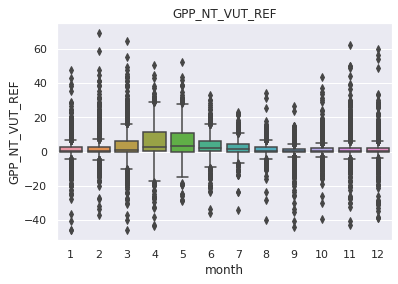

In [26]:
sns.boxplot(data=us_ton_hourly_00_df, x='month', y='GPP_NT_VUT_REF').set(title='GPP_NT_VUT_REF')

## Correlation by hour

[Text(0.5, 1.0, 'GPP_NT_VUT_REF')]

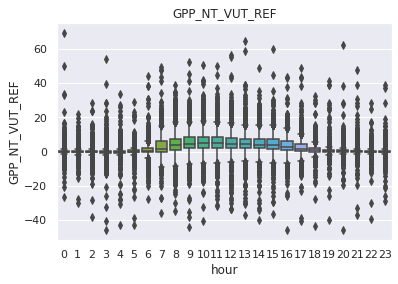

In [27]:
sns.boxplot(data=us_ton_hourly_00_df, x='hour', y='GPP_NT_VUT_REF').set(title='GPP_NT_VUT_REF')

## Correlation by hour and month

[Text(0.5, 1.0, 'December')]

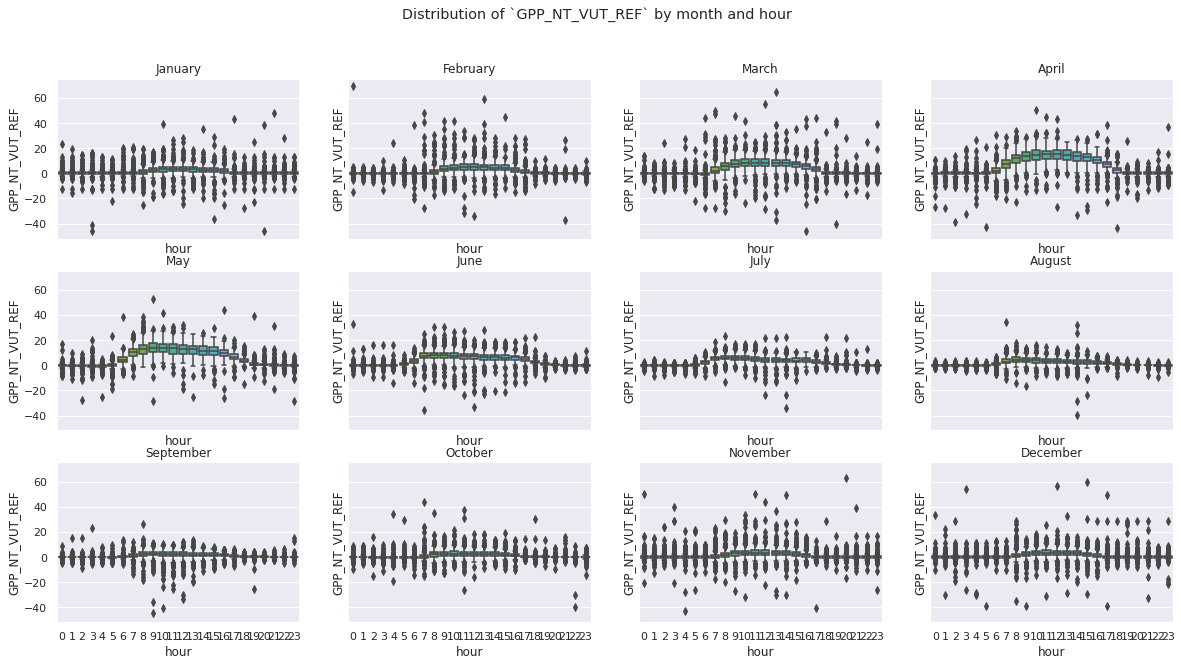

In [28]:
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True,figsize=(20,10))
fig.suptitle('Distribution of `GPP_NT_VUT_REF` by month and hour')
sns.boxplot(ax=axes[0, 0], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 1], x='hour', y='GPP_NT_VUT_REF').set(title='January')
sns.boxplot(ax=axes[0, 1], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 2], x='hour', y='GPP_NT_VUT_REF').set(title='February')
sns.boxplot(ax=axes[0, 2], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 3], x='hour', y='GPP_NT_VUT_REF').set(title='March')
sns.boxplot(ax=axes[0, 3], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 4], x='hour', y='GPP_NT_VUT_REF').set(title='April')
sns.boxplot(ax=axes[1, 0], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 5], x='hour', y='GPP_NT_VUT_REF').set(title='May')
sns.boxplot(ax=axes[1, 1], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 6], x='hour', y='GPP_NT_VUT_REF').set(title='June')
sns.boxplot(ax=axes[1, 2], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 7], x='hour', y='GPP_NT_VUT_REF').set(title='July')
sns.boxplot(ax=axes[1, 3], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 8], x='hour', y='GPP_NT_VUT_REF').set(title='August')
sns.boxplot(ax=axes[2, 0], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 9], x='hour', y='GPP_NT_VUT_REF').set(title='September')
sns.boxplot(ax=axes[2, 1], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 10], x='hour', y='GPP_NT_VUT_REF').set(title='October')
sns.boxplot(ax=axes[2, 2], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 11], x='hour', y='GPP_NT_VUT_REF').set(title='November')
sns.boxplot(ax=axes[2, 3], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 12], x='hour', y='GPP_NT_VUT_REF').set(title='December')


[Text(0.5, 1.0, 'December')]

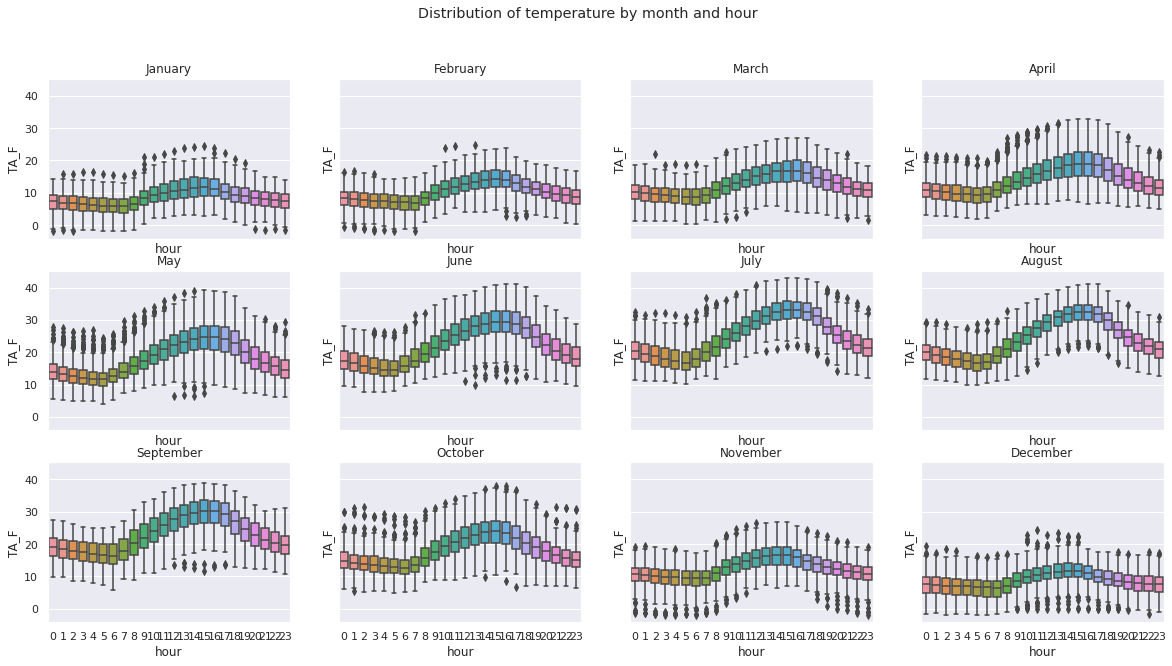

In [29]:
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True,figsize=(20,10))
fig.suptitle('Distribution of temperature by month and hour')
sns.boxplot(ax=axes[0, 0], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 1], x='hour', y='TA_F').set(title='January')
sns.boxplot(ax=axes[0, 1], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 2], x='hour', y='TA_F').set(title='February')
sns.boxplot(ax=axes[0, 2], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 3], x='hour', y='TA_F').set(title='March')
sns.boxplot(ax=axes[0, 3], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 4], x='hour', y='TA_F').set(title='April')
sns.boxplot(ax=axes[1, 0], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 5], x='hour', y='TA_F').set(title='May')
sns.boxplot(ax=axes[1, 1], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 6], x='hour', y='TA_F').set(title='June')
sns.boxplot(ax=axes[1, 2], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 7], x='hour', y='TA_F').set(title='July')
sns.boxplot(ax=axes[1, 3], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 8], x='hour', y='TA_F').set(title='August')
sns.boxplot(ax=axes[2, 0], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 9], x='hour', y='TA_F').set(title='September')
sns.boxplot(ax=axes[2, 1], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 10], x='hour', y='TA_F').set(title='October')
sns.boxplot(ax=axes[2, 2], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 11], x='hour', y='TA_F').set(title='November')
sns.boxplot(ax=axes[2, 3], data=us_ton_hourly_00_df[us_ton_hourly_00_df['month'] == 12], x='hour', y='TA_F').set(title='December')


---
*Following process use only Spark(N0 PANDAS)*

# Use parquet -> Spark df as preparation for global data

## DF to Parquet format
- Pandas is converted to parquet in order to make the following code usable with global data in AWS

In [30]:
type(us_ton_hourly_00_df)

pandas.core.frame.DataFrame

### Method 1

In [31]:
!pip install fastparquet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 95.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [32]:
us_ton_hourly_00_df.to_parquet('us_ton_hourly_00_pq', engine='fastparquet')
us_ton_hourly_df.to_parquet('us_ton_hourly_pq', engine='fastparquet')

### Method 2

In [33]:
# Convert df to parquet
import pyarrow as pa
import pyarrow.parquet as pq

# Convert DataFrame to Apache Arrow Table
table = pa.Table.from_pandas(us_ton_hourly_00_df)
# Second, write the table into parquet file say file_name.parquet
# Parquet with Brotli compression
pq.write_table(table, 'us_ton_hourly_00_pq.parquet')

## parquet to Spark df 

In [34]:
# Parquet is read from 
# When running Spark in AWS through the access to Azure, update the location and file name 
us_ton_hourly_00_sdf = spark.read.parquet('us_ton_hourly_00_pq')
us_ton_hourly_00_sdf2 = spark.read.parquet('us_ton_hourly_00_pq.parquet')
us_ton_hourly_sdf = spark.read.parquet('us_ton_hourly_pq')

In [35]:
us_ton_hourly_00_sdf.printSchema()

root
 |-- index: long (nullable = true)
 |-- TIMESTAMP_START: long (nullable = true)
 |-- TIMESTAMP_END: long (nullable = true)
 |-- TA_F: double (nullable = true)
 |-- TA_F_QC: long (nullable = true)
 |-- TA_ERA: double (nullable = true)
 |-- SW_IN_POT: double (nullable = true)
 |-- SW_IN_F: double (nullable = true)
 |-- SW_IN_F_QC: long (nullable = true)
 |-- SW_IN_ERA: double (nullable = true)
 |-- LW_IN_F: double (nullable = true)
 |-- LW_IN_F_QC: double (nullable = true)
 |-- LW_IN_ERA: double (nullable = true)
 |-- VPD_F: double (nullable = true)
 |-- VPD_F_QC: long (nullable = true)
 |-- VPD_ERA: double (nullable = true)
 |-- P_F: double (nullable = true)
 |-- P_F_QC: double (nullable = true)
 |-- P_ERA: double (nullable = true)
 |-- PA_F: double (nullable = true)
 |-- PA_F_QC: double (nullable = true)
 |-- PA_ERA: double (nullable = true)
 |-- NETRAD: double (nullable = true)
 |-- PPFD_IN: double (nullable = true)
 |-- G_F_MDS: double (nullable = true)
 |-- G_F_MDS_QC: double (

In [36]:
us_ton_hourly_00_sdf.show(truncate=False)

+-----+---------------+-------------+------+-------+------+---------+-------+----------+---------+-------+----------+---------+-----+--------+-------+---+------+-----+----+-------+------+-------+-------+-------+----------+--------+-----------+-------+--------+----------+--------+-----------+--------------+-----------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+---------------+---------------+-------------------+----+-----+---+----+-------+----------+--------------+------+------------------+------------------+------------------+------+-----+------+------+------+------+-----+----+---------+---------------+
|index|TIMESTAMP_START|TIMESTAMP_END|TA_F  |TA_F_QC|TA_ERA|SW_IN_POT|SW_IN_F|SW_IN_F_QC|SW_IN_ERA|LW_IN_F|LW_IN_F_QC|LW_IN_ERA|VPD_F|VPD_F_QC|VPD_ERA|P_F|P_F_QC|P_ERA|PA_F|PA_F_QC|PA_ERA|NETRAD |PPFD_IN|G_F_MDS|G_F_MDS_QC|LE_F_MDS|LE_F_MDS_QC|LE_CORR|H_F_MDS |H_F_MDS_QC|H_CORR  |NEE_VUT_REF|NEE_VUT_REF_QC|NEE_CUT_REF|NEE_CU

In [37]:
display(us_ton_hourly_00_sdf)

DataFrame[index: bigint, TIMESTAMP_START: bigint, TIMESTAMP_END: bigint, TA_F: double, TA_F_QC: bigint, TA_ERA: double, SW_IN_POT: double, SW_IN_F: double, SW_IN_F_QC: bigint, SW_IN_ERA: double, LW_IN_F: double, LW_IN_F_QC: double, LW_IN_ERA: double, VPD_F: double, VPD_F_QC: bigint, VPD_ERA: double, P_F: double, P_F_QC: double, P_ERA: double, PA_F: double, PA_F_QC: double, PA_ERA: double, NETRAD: double, PPFD_IN: double, G_F_MDS: double, G_F_MDS_QC: double, LE_F_MDS: double, LE_F_MDS_QC: double, LE_CORR: double, H_F_MDS: double, H_F_MDS_QC: double, H_CORR: double, NEE_VUT_REF: double, NEE_VUT_REF_QC: double, NEE_CUT_REF: double, NEE_CUT_REF_QC: double, GPP_NT_VUT_REF: double, GPP_DT_VUT_REF: double, GPP_NT_CUT_REF: double, GPP_DT_CUT_REF: double, RECO_NT_VUT_REF: double, RECO_DT_VUT_REF: double, RECO_NT_CUT_REF: double, RECO_DT_CUT_REF: double, datetime: string, year: bigint, month: bigint, day: bigint, hour: bigint, SITE_ID: string, date: string, NEE_VUT_REF_qa: double, SW_DIF: double

In [38]:
us_ton_hourly_00_sdf

DataFrame[index: bigint, TIMESTAMP_START: bigint, TIMESTAMP_END: bigint, TA_F: double, TA_F_QC: bigint, TA_ERA: double, SW_IN_POT: double, SW_IN_F: double, SW_IN_F_QC: bigint, SW_IN_ERA: double, LW_IN_F: double, LW_IN_F_QC: double, LW_IN_ERA: double, VPD_F: double, VPD_F_QC: bigint, VPD_ERA: double, P_F: double, P_F_QC: double, P_ERA: double, PA_F: double, PA_F_QC: double, PA_ERA: double, NETRAD: double, PPFD_IN: double, G_F_MDS: double, G_F_MDS_QC: double, LE_F_MDS: double, LE_F_MDS_QC: double, LE_CORR: double, H_F_MDS: double, H_F_MDS_QC: double, H_CORR: double, NEE_VUT_REF: double, NEE_VUT_REF_QC: double, NEE_CUT_REF: double, NEE_CUT_REF_QC: double, GPP_NT_VUT_REF: double, GPP_DT_VUT_REF: double, GPP_NT_CUT_REF: double, GPP_DT_CUT_REF: double, RECO_NT_VUT_REF: double, RECO_DT_VUT_REF: double, RECO_NT_CUT_REF: double, RECO_DT_CUT_REF: double, datetime: string, year: bigint, month: bigint, day: bigint, hour: bigint, SITE_ID: string, date: string, NEE_VUT_REF_qa: double, SW_DIF: double

In [39]:
us_ton_hourly_00_sdf2

DataFrame[TIMESTAMP_START: bigint, TIMESTAMP_END: bigint, TA_F: double, TA_F_QC: bigint, TA_ERA: double, SW_IN_POT: double, SW_IN_F: double, SW_IN_F_QC: bigint, SW_IN_ERA: double, LW_IN_F: double, LW_IN_F_QC: double, LW_IN_ERA: double, VPD_F: double, VPD_F_QC: bigint, VPD_ERA: double, P_F: double, P_F_QC: double, P_ERA: double, PA_F: double, PA_F_QC: double, PA_ERA: double, NETRAD: double, PPFD_IN: double, G_F_MDS: double, G_F_MDS_QC: double, LE_F_MDS: double, LE_F_MDS_QC: double, LE_CORR: double, H_F_MDS: double, H_F_MDS_QC: double, H_CORR: double, NEE_VUT_REF: double, NEE_VUT_REF_QC: double, NEE_CUT_REF: double, NEE_CUT_REF_QC: double, GPP_NT_VUT_REF: double, GPP_DT_VUT_REF: double, GPP_NT_CUT_REF: double, GPP_DT_CUT_REF: double, RECO_NT_VUT_REF: double, RECO_DT_VUT_REF: double, RECO_NT_CUT_REF: double, RECO_DT_CUT_REF: double, datetime: string, year: bigint, month: bigint, day: bigint, hour: bigint, SITE_ID: string, date: string, NEE_VUT_REF_qa: double, SW_DIF: double, EVI: double, 

In [40]:
print(type(us_ton_hourly_00_sdf))
print(type(us_ton_hourly_00_sdf2))
print(type(us_ton_hourly_sdf))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


# Correlation among features with pyspark

In [41]:
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

In [42]:
us_ton_hourly_00_sdf.columns

['index',
 'TIMESTAMP_START',
 'TIMESTAMP_END',
 'TA_F',
 'TA_F_QC',
 'TA_ERA',
 'SW_IN_POT',
 'SW_IN_F',
 'SW_IN_F_QC',
 'SW_IN_ERA',
 'LW_IN_F',
 'LW_IN_F_QC',
 'LW_IN_ERA',
 'VPD_F',
 'VPD_F_QC',
 'VPD_ERA',
 'P_F',
 'P_F_QC',
 'P_ERA',
 'PA_F',
 'PA_F_QC',
 'PA_ERA',
 'NETRAD',
 'PPFD_IN',
 'G_F_MDS',
 'G_F_MDS_QC',
 'LE_F_MDS',
 'LE_F_MDS_QC',
 'LE_CORR',
 'H_F_MDS',
 'H_F_MDS_QC',
 'H_CORR',
 'NEE_VUT_REF',
 'NEE_VUT_REF_QC',
 'NEE_CUT_REF',
 'NEE_CUT_REF_QC',
 'GPP_NT_VUT_REF',
 'GPP_DT_VUT_REF',
 'GPP_NT_CUT_REF',
 'GPP_DT_CUT_REF',
 'RECO_NT_VUT_REF',
 'RECO_DT_VUT_REF',
 'RECO_NT_CUT_REF',
 'RECO_DT_CUT_REF',
 'datetime',
 'year',
 'month',
 'day',
 'hour',
 'SITE_ID',
 'date',
 'NEE_VUT_REF_qa',
 'SW_DIF',
 'EVI',
 'NDVI',
 'NIRv',
 'b1',
 'b2',
 'b3',
 'b4',
 'b5',
 'b6',
 'b7',
 'IGBP',
 'koppen',
 'min_categorical']

## Choose features to see correlations

In [43]:
# Features used for this analysis
output_var = 'GPP_NT_VUT_REF'
# other options
output_related_var = ['NEE_VUT_REF', 'NEE_VUT_REF_QC',
       'NEE_CUT_REF', 'NEE_CUT_REF_QC', 'GPP_NT_VUT_REF', 'GPP_DT_VUT_REF',
       'GPP_NT_CUT_REF', 'GPP_DT_CUT_REF', 'RECO_NT_VUT_REF',
       'RECO_DT_VUT_REF', 'RECO_NT_CUT_REF', 'RECO_DT_CUT_REF',
       'NEE_VUT_REF_qa']

predictor_var = ['TA_F', 'TA_ERA','SW_IN_POT', 'SW_IN_F','SW_IN_ERA',
                 'LW_IN_F','LW_IN_ERA', 'VPD_F', 'VPD_ERA',
                 'P_F','P_ERA', 'PA_F',  'PA_ERA', 'NETRAD', 'PPFD_IN',
                 'LE_F_MDS', 'H_F_MDS', 'EVI', 'NDVI', 'NIRv',
                 'b1', 'b2', 'b3', 'b4', 'b5', 'b6','b7']

other_var =  ['TIMESTAMP_START', 'TIMESTAMP_END', 'datetime',
              'year', 'month', 'day', 'hour', 'SITE_ID', 'date', 'IGBP',
              'koppen']

qc_flags = ['TA_F_QC','SW_IN_F_QC','LW_IN_F_QC','VPD_F_QC',
            'P_F_QC', 'PA_F_QC','G_F_MDS_QC', 'LE_F_MDS_QC',
            'H_F_MDS_QC'] 

NA_list = ['G_F_MDS', 'LE_CORR', 'H_CORR','SW_DIF']
           # 'G_F_MDS_QC', 'LE_F_MDS_QC', 'H_F_MDS_QC' is skipped because they are included in qc flags
len(output_related_var + predictor_var + other_var + qc_flags + NA_list)
# output_var is included in output_related_var

64

In [44]:
# Features to observe correlation
corr_list = [output_var] + predictor_var 

## Result of XX:00 Spark df

In [45]:
us_ton_hourly_00_corr = us_ton_hourly_00_sdf.select(corr_list)

col_names = us_ton_hourly_00_corr.columns
features = us_ton_hourly_00_corr.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_00_df = pd.DataFrame(corr_mat)
corr_00_df.index, corr_00_df.columns = col_names, col_names
corr_00_df

,GPP_NT_VUT_REF,TA_F,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_ERA,LW_IN_F,LW_IN_ERA,VPD_F,VPD_ERA,...,EVI,NDVI,NIRv,b1,b2,b3,b4,b5,b6,b7
GPP_NT_VUT_REF,1.000000,0.178578,0.223537,0.582664,0.561015,0.557337,0.157237,0.157237,0.136708,0.197606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA_F,0.178578,1.000000,0.961665,0.452567,0.508659,0.491676,0.659932,0.659932,0.914120,0.882142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA_ERA,0.223537,0.961665,1.000000,0.532033,0.579542,0.574577,0.685358,0.685358,0.863196,0.902248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SW_IN_POT,0.582664,0.452567,0.532033,1.000000,0.947724,0.957762,0.440129,0.440129,0.435378,0.548509,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SW_IN_F,0.561015,0.508659,0.579542,0.947724,1.000000,0.978867,0.395958,0.395958,0.500897,0.612924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SW_IN_ERA,0.557337,0.491676,0.574577,0.957762,0.978867,1.000000,0.384147,0.384147,0.480119,0.603560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LW_IN_F,0.157237,0.659932,0.685358,0.440129,0.395958,0.384147,1.000000,1.000000,0.526139,0.520905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LW_IN_ERA,0.157237,0.659932,0.685358,0.440129,0.395958,0.384147,1.000000,1.000000,0.526139,0.520905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VPD_F,0.136708,0.914120,0.863196,0.435378,0.500897,0.480119,0.526139,0.526139,1.000000,0.940708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VPD_ERA,0.197606,0.882142,0.902248,0.548509,0.612924,0.603560,0.520905,0.520905,0.940708,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Result of full df

In [46]:
us_ton_hourly_corr = us_ton_hourly_sdf.select(corr_list)

col_names = us_ton_hourly_corr.columns
features = us_ton_hourly_corr.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
corr_df

,GPP_NT_VUT_REF,TA_F,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_ERA,LW_IN_F,LW_IN_ERA,VPD_F,VPD_ERA,...,EVI,NDVI,NIRv,b1,b2,b3,b4,b5,b6,b7
GPP_NT_VUT_REF,1.000000,0.178904,0.223171,0.584741,0.562549,0.558608,0.150766,0.150766,0.137069,0.197539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA_F,0.178904,1.000000,0.961963,0.452794,0.508904,0.495245,0.663783,0.663783,0.914197,0.882919,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA_ERA,0.223171,0.961963,1.000000,0.531014,0.578649,0.577184,0.688115,0.688115,0.863306,0.902341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SW_IN_POT,0.584741,0.452794,0.531014,1.000000,0.947807,0.958223,0.428069,0.428069,0.435688,0.547847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SW_IN_F,0.562549,0.508904,0.578649,0.947807,1.000000,0.979298,0.384186,0.384186,0.501115,0.612264,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SW_IN_ERA,0.558608,0.495245,0.577184,0.958223,0.979298,1.000000,0.372682,0.372682,0.484757,0.607914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LW_IN_F,0.150766,0.663783,0.688115,0.428069,0.384186,0.372682,1.000000,1.000000,0.531224,0.524250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LW_IN_ERA,0.150766,0.663783,0.688115,0.428069,0.384186,0.372682,1.000000,1.000000,0.531224,0.524250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VPD_F,0.137069,0.914197,0.863306,0.435688,0.501115,0.484757,0.531224,0.531224,1.000000,0.941274,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VPD_ERA,0.197539,0.882919,0.902341,0.547847,0.612264,0.607914,0.524250,0.524250,0.941274,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
type(us_ton_hourly_corr)

pyspark.sql.dataframe.DataFrame

## Divide feature with None and feature without None

In [48]:
display(us_ton_hourly_corr.head(5))

[Row(GPP_NT_VUT_REF=-0.480836, TA_F=26.759, TA_ERA=19.471, SW_IN_POT=0.0, SW_IN_F=0.0, SW_IN_ERA=0.0, LW_IN_F=301.311, LW_IN_ERA=301.311, VPD_F=23.47, VPD_ERA=11.608, P_F=0.0, P_ERA=0.0, PA_F=99.1, PA_ERA=99.113, NETRAD=-70.072, PPFD_IN=0.0, LE_F_MDS=3.85682, H_F_MDS=-24.7944, EVI=0.2562545930919896, NDVI=0.4411441087722778, NIRv=0.1155797564983368, b1=0.1016, b2=0.262, b3=0.0409, b4=0.0838, b5=0.3309, b6=0.2952, b7=0.161),
 Row(GPP_NT_VUT_REF=-0.488679, TA_F=26.156, TA_ERA=18.69, SW_IN_POT=0.0, SW_IN_F=0.0, SW_IN_ERA=0.0, LW_IN_F=301.311, LW_IN_ERA=301.311, VPD_F=22.01, VPD_ERA=10.341, P_F=0.0, P_ERA=0.0, PA_F=99.1, PA_ERA=99.113, NETRAD=-71.151, PPFD_IN=0.0, LE_F_MDS=2.1189, H_F_MDS=-25.5691, EVI=0.2562545930919896, NDVI=0.4411441087722778, NIRv=0.1155797564983368, b1=0.1016, b2=0.262, b3=0.0409, b4=0.0838, b5=0.3309, b6=0.2952, b7=0.161),
 Row(GPP_NT_VUT_REF=-0.212306, TA_F=26.185, TA_ERA=17.909, SW_IN_POT=0.0, SW_IN_F=0.0, SW_IN_ERA=0.0, LW_IN_F=292.413, LW_IN_ERA=292.413, VPD_F=22

In [49]:
# code that counts the number of None in each feature
from pyspark.sql.functions import isnull, when, count, col

us_ton_hourly_corr.select([count(when(isnull(c), c)).alias(c) for c in us_ton_hourly_corr.columns]).show()

+--------------+----+------+---------+-------+---------+-------+---------+-----+-------+---+-----+----+------+------+-------+--------+-------+----+----+----+----+----+----+----+----+----+----+
|GPP_NT_VUT_REF|TA_F|TA_ERA|SW_IN_POT|SW_IN_F|SW_IN_ERA|LW_IN_F|LW_IN_ERA|VPD_F|VPD_ERA|P_F|P_ERA|PA_F|PA_ERA|NETRAD|PPFD_IN|LE_F_MDS|H_F_MDS| EVI|NDVI|NIRv|  b1|  b2|  b3|  b4|  b5|  b6|  b7|
+--------------+----+------+---------+-------+---------+-------+---------+-----+-------+---+-----+----+------+------+-------+--------+-------+----+----+----+----+----+----+----+----+----+----+
|             0|   0|     0|        0|      0|        0|      0|        0|    0|      0|  0|    0|   0|     0|  7931|    233|       0|      0|2208|2208|2208|2208|2208|2208|2208|2304|5568|2208|
+--------------+----+------+---------+-------+---------+-------+---------+-----+-------+---+-----+----+------+------+-------+--------+-------+----+----+----+----+----+----+----+----+----+----+



## Create two lists - list of features with noNA/NA

In [50]:
us_ton_hourly_00_countNA = pd.DataFrame(us_ton_hourly_00_df[corr_list].isna().sum())
us_ton_hourly_countNA = pd.DataFrame(us_ton_hourly_df[corr_list].isna().sum())

corr_NA0_list = list(us_ton_hourly_00_countNA[us_ton_hourly_00_countNA[0] == 0].index)
corr_NA_list = list(us_ton_hourly_00_countNA[us_ton_hourly_00_countNA[0] != 0].index)

In [51]:
corr_NA_list

['NETRAD',
 'PPFD_IN',
 'EVI',
 'NDVI',
 'NIRv',
 'b1',
 'b2',
 'b3',
 'b4',
 'b5',
 'b6',
 'b7']

In [52]:
corr_NA0_list

['GPP_NT_VUT_REF',
 'TA_F',
 'TA_ERA',
 'SW_IN_POT',
 'SW_IN_F',
 'SW_IN_ERA',
 'LW_IN_F',
 'LW_IN_ERA',
 'VPD_F',
 'VPD_ERA',
 'P_F',
 'P_ERA',
 'PA_F',
 'PA_ERA',
 'LE_F_MDS',
 'H_F_MDS']

## Correlation of features with zero NA

In [53]:
us_ton_hourly_corr2 = us_ton_hourly_sdf.select(corr_NA0_list)

col_names = us_ton_hourly_corr2.columns
features = us_ton_hourly_corr2.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_df2 = pd.DataFrame(corr_mat)
corr_df2.index, corr_df2.columns = col_names, col_names
corr_df2

,GPP_NT_VUT_REF,TA_F,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_ERA,LW_IN_F,LW_IN_ERA,VPD_F,VPD_ERA,P_F,P_ERA,PA_F,PA_ERA,LE_F_MDS,H_F_MDS
GPP_NT_VUT_REF,1.000000,0.178904,0.223171,0.584741,0.562549,0.558608,0.150766,0.150766,0.137069,0.197539,-0.038383,-0.027689,-0.023144,-0.012510,0.672214,0.440713
TA_F,0.178904,1.000000,0.961963,0.452794,0.508904,0.495245,0.663783,0.663783,0.914197,0.882919,-0.102292,-0.121931,-0.353646,-0.399103,0.256023,0.519824
TA_ERA,0.223171,0.961963,1.000000,0.531014,0.578649,0.577184,0.688115,0.688115,0.863306,0.902341,-0.092770,-0.121905,-0.340824,-0.397927,0.297883,0.594798
SW_IN_POT,0.584741,0.452794,0.531014,1.000000,0.947807,0.958223,0.428069,0.428069,0.435688,0.547847,-0.018695,-0.023815,-0.047620,-0.085940,0.678279,0.885226
SW_IN_F,0.562549,0.508904,0.578649,0.947807,1.000000,0.979298,0.384186,0.384186,0.501115,0.612264,-0.074125,-0.080360,-0.039952,-0.079662,0.688766,0.943294
SW_IN_ERA,0.558608,0.495245,0.577184,0.958223,0.979298,1.000000,0.372682,0.372682,0.484757,0.607914,-0.070921,-0.089259,-0.027236,-0.070421,0.673377,0.927474
LW_IN_F,0.150766,0.663783,0.688115,0.428069,0.384186,0.372682,1.000000,1.000000,0.531224,0.524250,0.113958,0.141844,-0.418583,-0.453656,0.218215,0.419250
LW_IN_ERA,0.150766,0.663783,0.688115,0.428069,0.384186,0.372682,1.000000,1.000000,0.531224,0.524250,0.113958,0.141844,-0.418583,-0.453656,0.218215,0.419250
VPD_F,0.137069,0.914197,0.863306,0.435688,0.501115,0.484757,0.531224,0.531224,1.000000,0.941274,-0.106816,-0.125673,-0.282896,-0.318585,0.225539,0.506138
VPD_ERA,0.197539,0.882919,0.902341,0.547847,0.612264,0.607914,0.524250,0.524250,0.941274,1.000000,-0.111616,-0.144790,-0.224616,-0.274511,0.291828,0.619550


## Correlation table 1 - full observations
 - None of the observations are dropped because of NA 

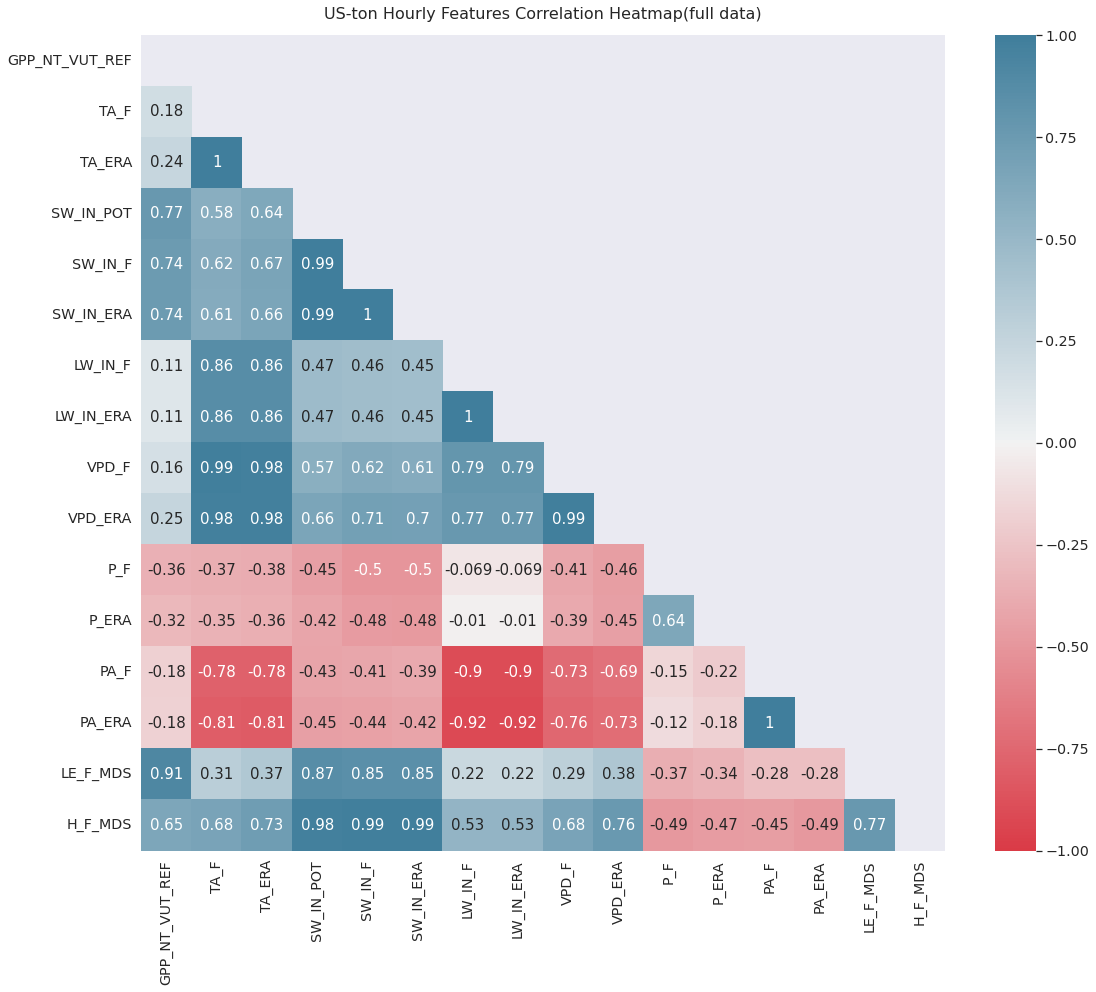

In [54]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(18, 15))

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_df2)

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.3)
heatmap = sns.heatmap(corr_df2.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":15}, mask=matrix)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('US-ton Hourly Features Correlation Heatmap(full data)', fontdict={'fontsize':16}, pad=16)

plt.savefig("corr1.png",bbox_inches='tight')


### Another layout 

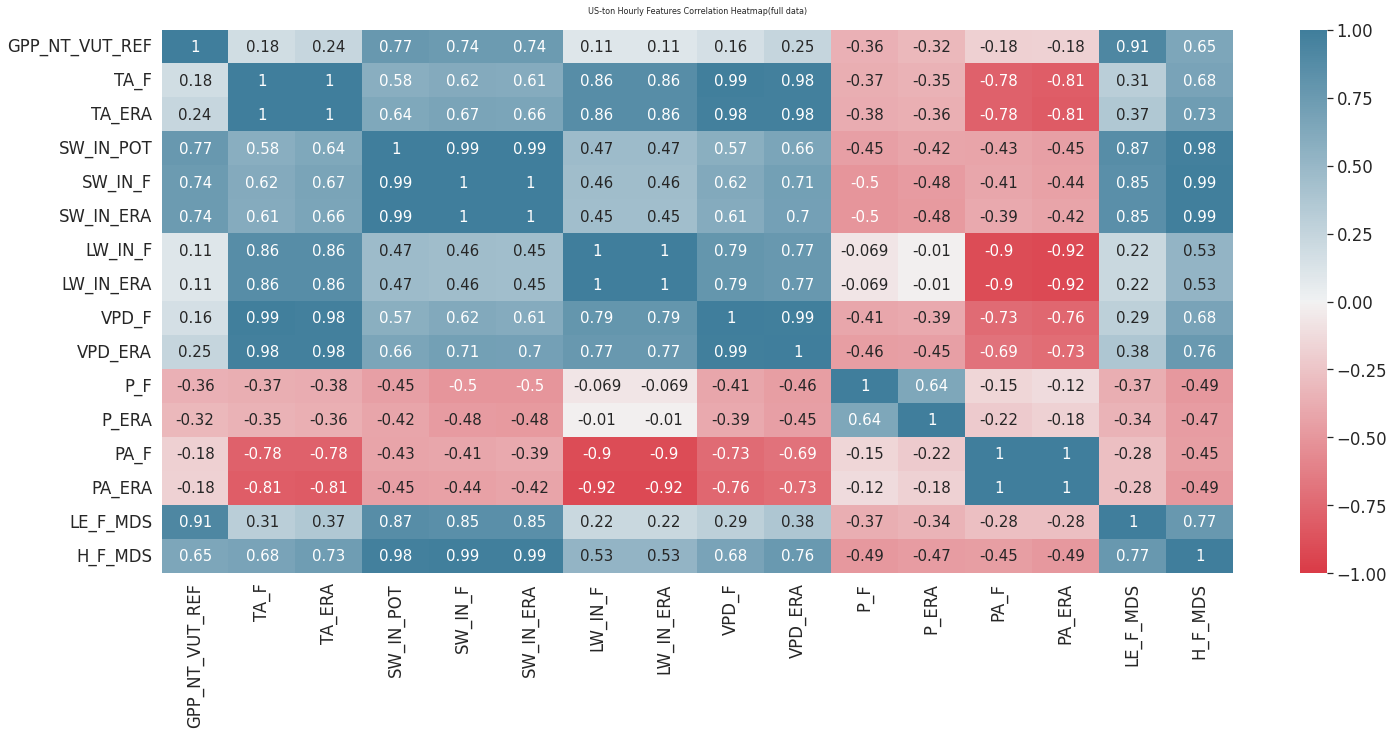

In [55]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(24, 10))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.5)
heatmap = sns.heatmap(corr_df2.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":15})
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('US-ton Hourly Features Correlation Heatmap(full data)', fontdict={'fontsize':8}, pad=16)

plt.savefig("corr2.png",bbox_inches='tight')


## Correlation table 2 - drop rows with NA

In [56]:
us_ton_hourly_corr3 = us_ton_hourly_sdf.select(corr_list)

### Drop NA-contained rows

In [57]:
us_ton_hourly_corr3_NAdrop = us_ton_hourly_corr3.na.drop("any")
us_ton_hourly_corr3_NAdrop.show()

+--------------+------+------+---------+-------+---------+-------+---------+-----+-------+---+-----+----+------+-------+-------+--------+--------+------------------+------------------+------------------+------+-----+------+------+------+------+-----+
|GPP_NT_VUT_REF|  TA_F|TA_ERA|SW_IN_POT|SW_IN_F|SW_IN_ERA|LW_IN_F|LW_IN_ERA|VPD_F|VPD_ERA|P_F|P_ERA|PA_F|PA_ERA| NETRAD|PPFD_IN|LE_F_MDS| H_F_MDS|               EVI|              NDVI|              NIRv|    b1|   b2|    b3|    b4|    b5|    b6|   b7|
+--------------+------+------+---------+-------+---------+-------+---------+-----+-------+---+-----+----+------+-------+-------+--------+--------+------------------+------------------+------------------+------+-----+------+------+------+------+-----+
|     -0.480836|26.759|19.471|      0.0|    0.0|      0.0|301.311|  301.311|23.47| 11.608|0.0|  0.0|99.1|99.113|-70.072|    0.0| 3.85682|-24.7944|0.2562545930919896|0.4411441087722778|0.1155797564983368|0.1016|0.262|0.0409|0.0838|0.3309|0.2952|0.1

Rows were reduced from 174528 -> 104846

In [58]:
rows = us_ton_hourly_corr3_NAdrop.count()
print(f"DataFrame Rows count : {rows}")

DataFrame Rows count : 217677


In [59]:
col_names = us_ton_hourly_corr3_NAdrop.columns
features = us_ton_hourly_corr3_NAdrop.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_df3_NAdrop = pd.DataFrame(corr_mat)
corr_df3_NAdrop.index, corr_df3_NAdrop.columns = col_names, col_names
corr_df3_NAdrop

,GPP_NT_VUT_REF,TA_F,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_ERA,LW_IN_F,LW_IN_ERA,VPD_F,VPD_ERA,...,EVI,NDVI,NIRv,b1,b2,b3,b4,b5,b6,b7
GPP_NT_VUT_REF,1.000000,0.177242,0.222162,0.591202,0.568205,0.564015,0.155342,0.155342,0.134950,0.195682,...,0.336769,0.281031,0.336433,-0.165842,0.181753,-0.127342,-0.071631,0.017087,-0.130262,-0.150566
TA_F,0.177242,1.000000,0.964402,0.450872,0.502959,0.490995,0.678851,0.678851,0.917252,0.885732,...,-0.142030,-0.415383,-0.085956,0.612916,0.497725,0.628160,0.643271,0.647064,0.636836,0.586710
TA_ERA,0.222162,0.964402,1.000000,0.529939,0.574871,0.573422,0.703711,0.703711,0.864902,0.902436,...,-0.132968,-0.409904,-0.075862,0.615041,0.510268,0.631285,0.648488,0.654654,0.639857,0.590140
SW_IN_POT,0.591202,0.450872,0.529939,1.000000,0.951332,0.960714,0.437247,0.437247,0.435572,0.547535,...,0.084792,-0.011179,0.100602,0.113364,0.210815,0.130337,0.156566,0.195576,0.139753,0.124012
SW_IN_F,0.568205,0.502959,0.574871,0.951332,1.000000,0.980645,0.394245,0.394245,0.496595,0.608137,...,0.060644,-0.052159,0.080302,0.162927,0.237966,0.179105,0.201619,0.243009,0.195363,0.178609
SW_IN_ERA,0.564015,0.490995,0.573422,0.960714,0.980645,1.000000,0.384444,0.384444,0.481347,0.603702,...,0.059381,-0.051678,0.078819,0.161362,0.234955,0.177088,0.199461,0.240512,0.193973,0.177279
LW_IN_F,0.155342,0.678851,0.703711,0.437247,0.394245,0.384444,1.000000,1.000000,0.545307,0.540186,...,-0.053479,-0.262156,-0.010733,0.432143,0.400614,0.449926,0.484532,0.472879,0.431449,0.393498
LW_IN_ERA,0.155342,0.678851,0.703711,0.437247,0.394245,0.384444,1.000000,1.000000,0.545307,0.540186,...,-0.053479,-0.262156,-0.010733,0.432143,0.400614,0.449926,0.484532,0.472879,0.431449,0.393498
VPD_F,0.134950,0.917252,0.864902,0.435572,0.496595,0.481347,0.545307,0.545307,1.000000,0.943703,...,-0.160796,-0.373015,-0.114659,0.520497,0.380766,0.525358,0.530359,0.528307,0.544787,0.515653
VPD_ERA,0.195682,0.885732,0.902436,0.547535,0.608137,0.603702,0.540186,0.540186,0.943703,1.000000,...,-0.161469,-0.362995,-0.116741,0.501557,0.361003,0.504359,0.505246,0.504743,0.524878,0.499722


## Correlation table 2 - NA dropped
 - Apply all the possible features
 - Instead, row that include NA are dropped from DF 

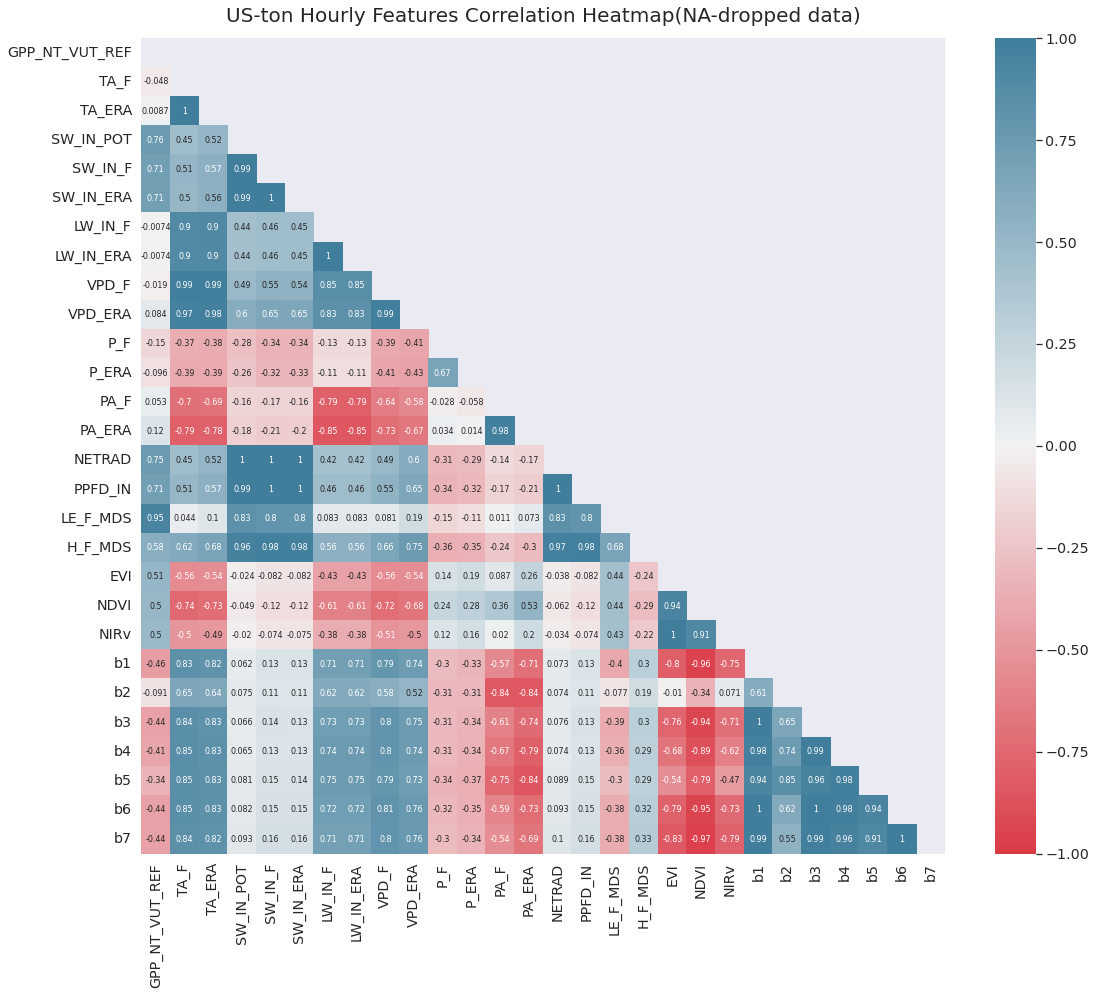

In [60]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(18, 15))

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_df3_NAdrop)

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.3)
heatmap = sns.heatmap(corr_df3_NAdrop.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":8}, mask=matrix)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('US-ton Hourly Features Correlation Heatmap(NA-dropped data)', fontdict={'fontsize':20}, pad=16)

plt.savefig("corr1.png",bbox_inches='tight')


### Another layout 

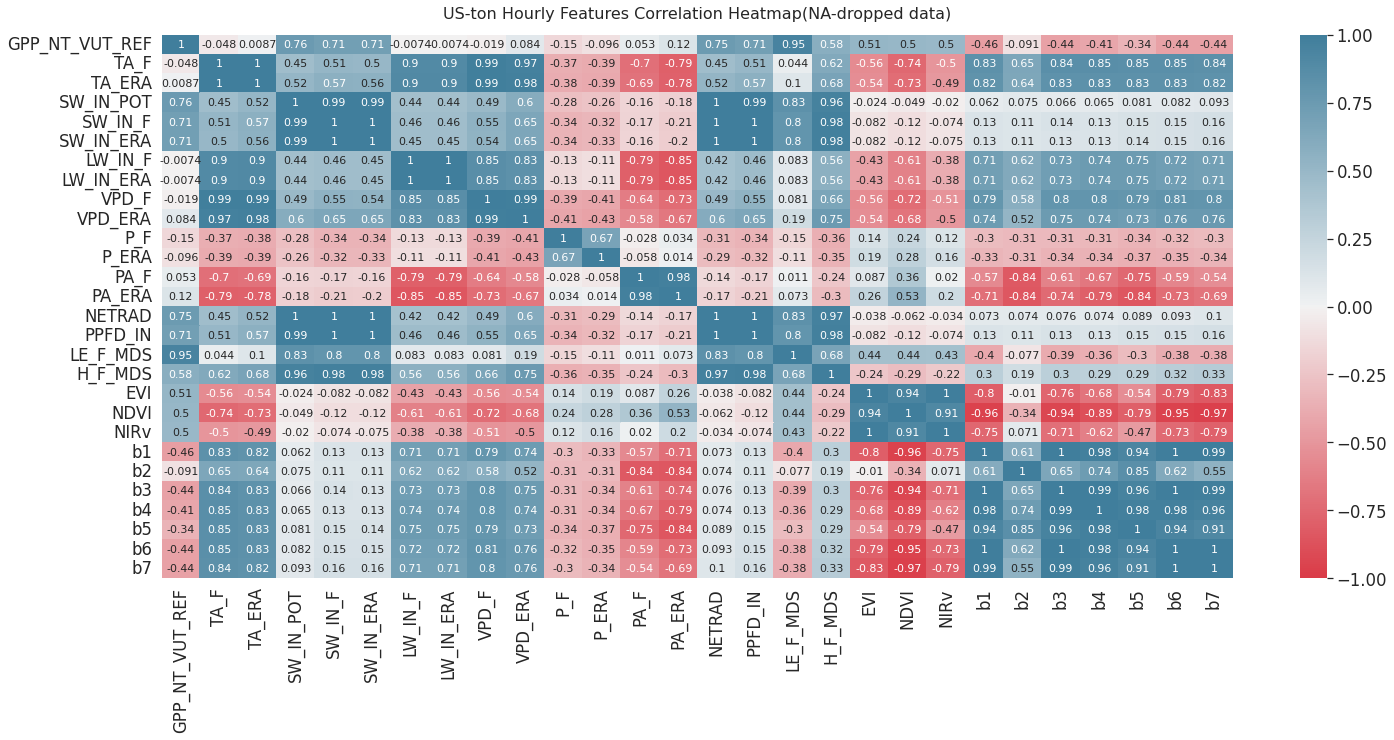

In [61]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(24, 10))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.5)
heatmap = sns.heatmap(corr_df3_NAdrop.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":11})
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('US-ton Hourly Features Correlation Heatmap(NA-dropped data)', fontdict={'fontsize':16}, pad=16)

plt.savefig("corr2.png",bbox_inches='tight')
